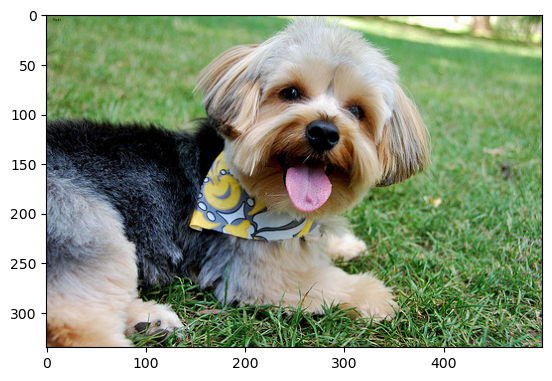

mps


In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import imageio
img_path="./oxford_pet/images/yorkshire_terrier_96.jpg"
import numpy as np
# train test split
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from torchvision.models import resnet18, ResNet18_Weights


# Load the image and display it
plt.imshow(plt.imread(img_path))
plt.show()


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)



In [147]:
# get all image paths from "./images" folder
import os
from glob import glob
paths = glob("./oxford_pet/images/*.jpg")

# the labels are the part of the image name, before the first digits. Use regex
import re
labels=[re.search(r"(.+?)[0-9]", os.path.basename(path)).group(1) for path in paths]


# create dictionary of labels and their index
label_to_idx = {label: i for i, label in enumerate(set(labels))}
idx_to_label = {i: label for i, label in enumerate(set(labels))}
label_idx = [label_to_idx[label] for label in labels]

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(paths, label_idx, test_size=0.2, random_state=42, stratify=label_idx)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


scottish_terrier_
torch.Size([3, 224, 224])


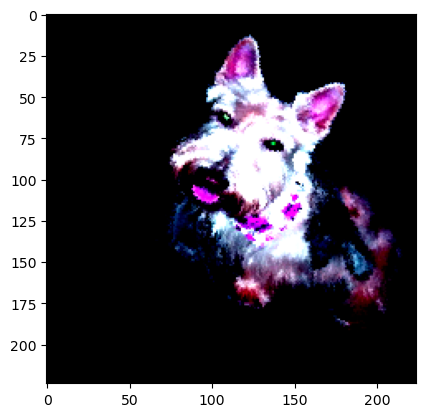

In [126]:
# create torch dataset with image path and label
class PetDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = imageio.v2.imread(self.paths[idx])
        # if image is grayscale, convert it to rgb
        try:
            if img.shape[2] == 4:
                img = img[:, :, :3]
        except:
            #image is grayscale and has only 2 dimensions
            # insert a dimension for the channel and repeat the image 3 times
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

myTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.6),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # imagenet normalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

ds= PetDataset(x_train, y_train, myTransforms)
img, label = ds[0]
plt.imshow(img.permute(1, 2, 0))
print(idx_to_label[label.item()])
print(img.shape)

In [127]:


def validate(model):
    model.eval()
    correct = 0
    total = 0
    for xb, yb in iter(test_loader):
        xb=xb.to(device)
        yb=yb.to(device)
        pred = model(x)
        _, predicted = torch.max(pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    model.train()
    return 100 * correct / total

def create_model():
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2048, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1000, 37)
    )
    return model

In [128]:
from torchvision.models import ResNet50_Weights
# model is resnet50
from torchvision.models import resnet50
model=create_model()
#model = model.to(device)

batch_size=64

train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(PetDataset(x_test, y_test, myTransforms), batch_size=batch_size, shuffle=True)

xb, yb = next(iter(train_loader))
model(xb)

tensor([[ 0.6775, -0.0804, -0.1408,  ...,  0.1321,  0.5303,  0.8324],
        [ 0.2880,  0.2674, -1.0226,  ...,  0.2835, -0.9777,  0.2172],
        [ 0.4466, -0.0387, -0.0068,  ...,  0.2824,  0.3854, -0.0631],
        ...,
        [ 0.1935, -0.9956, -0.6868,  ...,  0.5099,  1.7378,  0.2511],
        [ 0.7794, -0.4261, -0.6963,  ..., -0.8374,  0.6604,  0.8328],
        [ 0.2398,  0.5307, -0.1444,  ...,  0.0877, -0.2999,  0.2044]],
       grad_fn=<AddmmBackward0>)

In [130]:
from tqdm.notebook import tqdm

model = create_model()
model.to(device)
model.train()
# freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True


epochs=3
lr=0.001

loss_func=nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.7)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)

# learnrate scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=40, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

from torch.optim.lr_scheduler import OneCycleLR


scheduler = OneCycleLR(optimizer,
                       max_lr = lr, # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = len(train_loader), # The number of steps per epoch to train for.
                       epochs = epochs, # The number of epochs to train for.
                       anneal_strategy = 'cos') # Specifies the annealing strategy

running_loss=0
current_time=time.time()
batch_count=len(train_loader)

for epoch in tqdm(range(epochs)):
    c=0
    for x, y in train_loader:
        x=x.to(device)
        y=y.to(device)
        y_hat=model(x)
        loss=loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        # print statistics
        if c % 20 == 19:    # print every 20 mini-batches
            current_lr=optimizer.param_groups[0]['lr']
            print('Epoch %d | %d/%d MiniBatch | loss: %.3f | lr: %.6f' %
                  (epoch + 1, c + 1, batch_count, running_loss/20, current_lr))
            running_loss=0
            current_time=time.time()
        c=c+1
        scheduler.step()
    print("End of Epoch %d | accuracy: %.3f | time: %.3f" % (epoch + 1, validate(model), time.time()-current_time))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 | 20/93 MiniBatch | loss: 3.634 | lr: 0.000160
Epoch 1 | 40/93 MiniBatch | loss: 3.150 | lr: 0.000477
Epoch 1 | 60/93 MiniBatch | loss: 2.139 | lr: 0.000818
Epoch 1 | 80/93 MiniBatch | loss: 1.306 | lr: 0.000995
End of Epoch 1 | accuracy: 100.000 | time: 19.247
Epoch 2 | 20/93 MiniBatch | loss: 1.558 | lr: 0.000945
Epoch 2 | 40/93 MiniBatch | loss: 0.869 | lr: 0.000851
Epoch 2 | 60/93 MiniBatch | loss: 0.772 | lr: 0.000720
Epoch 2 | 80/93 MiniBatch | loss: 0.708 | lr: 0.000567
End of Epoch 2 | accuracy: 79.167 | time: 19.291
Epoch 3 | 20/93 MiniBatch | loss: 1.123 | lr: 0.000307
Epoch 3 | 40/93 MiniBatch | loss: 0.618 | lr: 0.000171
Epoch 3 | 60/93 MiniBatch | loss: 0.646 | lr: 0.000069
Epoch 3 | 80/93 MiniBatch | loss: 0.604 | lr: 0.000011
End of Epoch 3 | accuracy: 95.833 | time: 333.496


In [138]:

model.eval()
y_true=[]
y_pred=[]
for x, y in test_loader:
    x=x.to(device)
    y=y.to(device)
    y_hat=model(x)
    _, predicted = torch.max(y_hat, 1)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
cf_matrix = confusion_matrix(y_true, y_pred)


<Axes: >

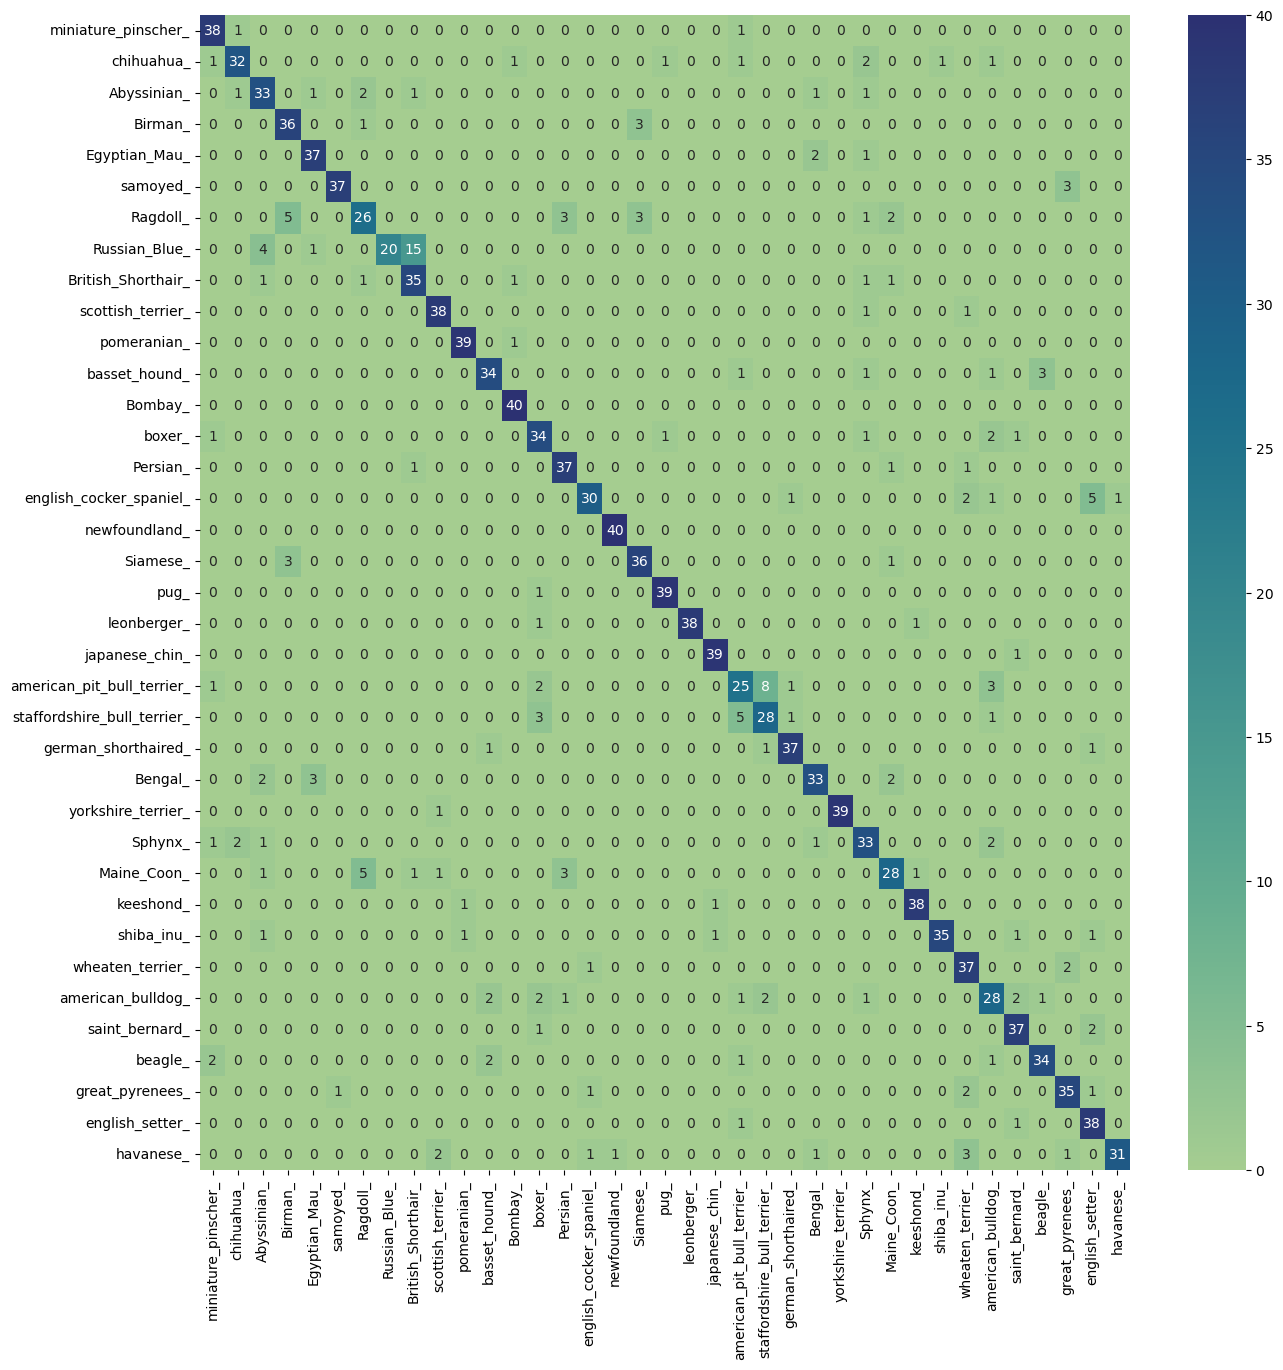

In [139]:
fig, ax = plt.subplots(figsize=(15, 15))
classes = list(idx_to_label.values())
sn.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt = '', ax=ax, cmap='crest')

Die Y-Achse der Confusion Matrix zeigt die tatsächlichen Klassen, die X-Achse die vorhergesagten Klassen. Die Diagonale zeigt die Klassen, die richtig vorhergesagt wurden. Die anderen Werte zeigen die falsch vorhergesagten Klassen.

In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

                             precision    recall  f1-score   support

        miniature_pinscher_       0.86      0.95      0.90        40
                 chihuahua_       0.89      0.80      0.84        40
                Abyssinian_       0.77      0.82      0.80        40
                    Birman_       0.82      0.90      0.86        40
              Egyptian_Mau_       0.88      0.93      0.90        40
                   samoyed_       0.97      0.93      0.95        40
                   Ragdoll_       0.74      0.65      0.69        40
              Russian_Blue_       1.00      0.50      0.67        40
         British_Shorthair_       0.66      0.88      0.75        40
          scottish_terrier_       0.90      0.95      0.93        40
                pomeranian_       0.95      0.97      0.96        40
              basset_hound_       0.87      0.85      0.86        40
                    Bombay_       0.93      1.00      0.96        40
                     boxer_      

In [142]:
confusion_matrix(y_true, y_pred)

array([[38,  1,  0, ...,  0,  0,  0],
       [ 1, 32,  0, ...,  0,  0,  0],
       [ 0,  1, 33, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 35,  1,  0],
       [ 0,  0,  0, ...,  0, 38,  0],
       [ 0,  0,  0, ...,  1,  0, 31]])